# What is an Autoencoder?

An autoencoder is a great tool to recreate an input. In a simple word,
the machine takes, let's say an image, and can produce a closely related
picture. The input in this kind of neural network is unlabelled, meaning
the network is capable of learning without supervision. More precisely,
the input is encoded by the network to focus only on the most critical
feature. This is one of the reasons why autoencoder is popular for
dimensionality reduction. Besides, autoencoders can be used to produce
**generative learning models**. For example, the neural network can be
trained with a set of faces and then can produce new faces.

In this tutorial, you will learn what an autoencoder is and how to build
such type of network with Tensorflow to reconstruct an image.

## How does it work?

The purpose of an autoencoder is to produce an approximation of the
input by focusing only on the essential features. You may think why not
merely learn how to copy and paste the input to produce the output. In
fact, an autoencoder is a set of constraints that force the network to
learn new ways to represent the data, different from merely copying the
output.

A typical autoencoder is defined with an input, an internal
representation and an output (an approximation of the input). The
learning occurs in the layers attached to the internal representation.
In fact, there are two main blocks of layers which looks like a
traditional neural network. The slight difference is the layer
containing the output must be equal to the input. In the picture below,
the original input goes into the first block called the **encoder**.
This internal representation compresses (reduces) the size of the input.
In the second block occurs the reconstruction of the input. This is the
decoding phase.

![](https://github.com/thomaspernet/Tensorflow/blob/master/tensorflow/22_autoencoder_v4_files/image001.png)

The model will update the weights by minimizing the loss function. The
model is penalized if the reconstruction output is different from the
input.

Concretely, imagine a picture with a size of 50x50 (i.e., 250 pixels)
and a neural network with just one hidden layer composed of one hundred
neurons. The learning is done on a feature map which is two times
smaller than the input. It means the network needs to find a way to
reconstruct 250 pixels with only a vector of neurons equal to 100.

## Stacked Autoencoder Example

In this tutorial, you will learn how to use a stacked autoencoder. The
architecture is similar to a traditional neural network. The input goes
to a hidden layer in order to be *compressed*, or reduce its size, and
then reaches the reconstruction layers. The objective is to produce an
output image as close as the original. The model has to learn a way to
achieve its task under a set of constraints, that is, with a lower
dimension.

Nowadays, autoencoders are mainly used to denoise an image. Imagine an
image with scratches; a human is still able to recognize the content.
The idea of denoising autoencoder is to add noise to the picture to
force the network to learn the pattern behind the data.

The other useful family of autoencoder is variational autoencoder. This
type of network can generate new images. Imagine you train a network
with the image of a man; such a network can produce new faces.

## Build an Autoencoder with TensorFlow

In this tutorial, you will learn how to build a stacked autoencoder to
reconstruct an image.

You will use the [CIFAR-10
dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which contains
60000 32x32 color images. The dataset is already split between 50000
images for training and 10000 for testing. There are up to ten classes:

-   Airplane

-   Automobile

-   Bird

-   Cat

-   Deer

-   Dog

-   Frog

-   Horse

-   Ship

-   Truck

You need download the images in this [URL](https://www.cs.toronto.edu/\~kriz/cifar.html) and unzip it. The folder
*for-10-batches-py* contains five batches of data with 10000 images each
in a random order.

Before you build and train your model, you need to apply some data
processing. You will proceed as follow:

1.  Import the data

2.  Convert the data to black and white format

3.  Append all the batches

4.  Construct the training dataset

5.  Construct an image visualizer

## Image preprocessing

**Step 1:** Import the data.

According to the official website, you can upload the data with the
following code. The code will load the data in a dictionary with the
**data** and the **label**. Note that the code is a function.

In [1]:
import numpy as np
import tensorflow as tf

import pickle
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

/Users/Thomas/anaconda3/envs/hello-tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


**Step 2:** Convert the data to black and white format

For simplicity, you will convert the data to a grayscale. That is, with
only one dimension against three for colors image. Most of the neural
network works only with one dimension input.

In [2]:
def grayscale(im):
    return im.reshape(im.shape[0], 3, 32, 32).mean(1).reshape(im.shape[0], -1)

**Step 3:** Append all the batches

Now that both functions are created and the dataset loaded, you can
write a loop to append the data in memory. If you check carefully, the
unzip file with the data is named `data_batch_` with a number from 1 to
5. You can loop over the files and append it to `data`.

When this step is done, you convert the colours data to a gray scale
format. As you can see, the shape of the data is 50000 and 1024. The
32\*32 pixels are now flatten to 2014.

In [4]:
# Load the data into memory
data, labels = [], []
## Loop over the b
for i in range(1, 6):
    filename = '/Users/Thomas/Downloads/cifar-10-batches-py/data_batch_' + str(i)
    open_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, open_data['data']))
        labels = np.hstack((labels, open_data['labels']))
    else:
        data = open_data['data']
        labels = open_data['labels']

data = grayscale(data)
x = np.matrix(data)
y = np.array(labels)
print(x.shape)

(50000, 1024)


**Step 4:** Construct the training dataset

To make the training faster and easier, you will train a model on the
horse images only. The horses are the seventh class in the label data.
As mentioned in the documentation of the CIFAR-10 dataset, each class
contains 5000 images. You can print the shape of the data to confirm
there are 5.000 images with 1024 columns.

In [5]:
horse_i = np.where(y == 7)[0]
horse_x = x[horse_i]
print(np.shape(horse_x)) 

(5000, 1024)


**Step 5:** Construct an image visualizer

Finally, you construct a function to plot the images. You will need this
function to print the reconstructed image from the autoencoder.

An easy way to print images is to use the object `imshow` from the
`matplotlib` library. Note that, you need to convert the shape of the
data from 1024 to 32\*32 (i.e. format of an image). *\# To plot pretty
figures*\
%matplotlib inline\
import matplotlib\
import matplotlib.pyplot as plt

In [6]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
def plot_image(image, shape=[32, 32], cmap = "Greys_r"):
    plt.imshow(image.reshape(shape), cmap=cmap,interpolation="nearest")
    plt.axis("off")   

The function takes 3 arguments:

-   Image:  the input
-   Shape: list, the dimension of the image
-   Cmap:choose the color map. By default, grey

You can try to plot the first image in the dataset. You should see a man
on a horse.

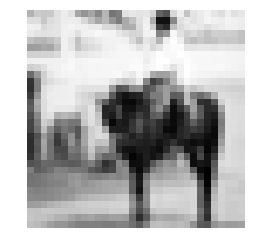

In [8]:
plot_image(horse_x[1], shape=[32, 32], cmap = "Greys_r")

![](https://github.com/thomaspernet/Tensorflow/blob/master/tensorflow/22_autoencoder_v4_files/image002.png)

## Set Dataset Estimator

All right, now that the dataset is ready to use, you can start to use
Tensorflow. Before to build the model, let's use the `Dataset` estimator
of Tensorflow to feed the network.

You will build a `Dataset` with TensorFlow estimator. To refresh your
mind, you need to use:

-   `from_tensor_slices`

-   `repeat`

-   `batch`

The full code to build the dataset is:

In [9]:
## Parameters
n_inputs = 32 * 32
BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)

Note that, `x` is a placeholder with the following shape:

-   `[None,n_inputs]`: Set to `None` because the number of image feed to
    the network is equal to the batch size.

for details, please refer to the tutorial on linear
regression.

After that, you need to create the iterator. Without this line of code,
no data will go through the pipeline.

In [10]:
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

Now that the pipeline is ready, you can check if the first image is the
same as before (i.e., a man on a horse).

You set the batch size to 1 because you only want to feed the dataset
with one image. You can see the dimension of the data with
`print(sess.run(features).shape)`. It is equal to (1, 1024). 1 means
only one image with 1024 is feed each. If the batch size is set to two,
then two images will go through the pipeline. (Don't change the batch
size. Otherwise, it will throw an error. Only one image at a time can go
to the function `plot_image()`.

(1, 1024)


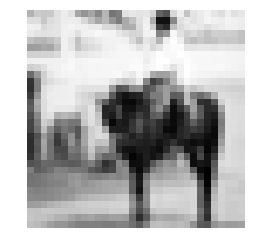

In [11]:
## Parameters
n_inputs = 32 * 32
BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
## Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

## Print the image
with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                         batch_size: BATCH_SIZE}) 
    print(sess.run(features).shape) 
    plot_image(sess.run(features), shape=[32, 32], cmap = "Greys_r")


![](https://github.com/thomaspernet/Tensorflow/blob/master/tensorflow/22_autoencoder_v4_files/image002.png)

## Build the network

It is time to construct the network. You will train a stacked
autoencoder, that is, a network with multiple hidden layers.

Your network will have one input layers with 1024 points, i.e., 32x32,
the shape of the image.

The encoder block will have one top hidden layer with 300 neurons, a
central layer with 150 neurons. The decoder block is symmetric to the
encoder. You can visualize the network in the picture below. Note that
you can change the values of hidden and central layers.

![](https://github.com/thomaspernet/Tensorflow/blob/master/tensorflow/22_autoencoder_v4_files/image003.png)

Building an autoencoder is very similar to any other deep learning
model.

You will construct the model following these steps:

1.  Define the parameters

2.  Define the layers

3.  Define the architecture

4.  Define the optimization

5.  Run the model

6.  Evaluate the model

In the previous section, you learned how to create a pipeline to feed
the model, so there is no need to create once more the dataset. You will
construct an autoencoder with four layers. You use the Xavier
initialization. This is a technique to set the initial weights equal to
the variance of both the input and output. Finally, you use the elu
activation function. You regularize the loss function with L2
regularizer.

**Step 1:** Define the parameters

The first step implies to define the number of neurons in each layer,
the learning rate and the hyperparameter of the regularizer.

Before that, you import the function partially. It is a better method to
define the parameters of the dense layers. The code below defines the
values of the autoencoder architecture. As listed before, the
autoencoder has two layers, with 300 neurons in the first layers and 150
in the second layers. Their values are stored in `n_hidden_1` and
`n_hidden_2`.

You need to define the learning rate and the L2 hyperparameter. The
values are stored in `learning_rate` and `l2_reg

In [12]:
from functools import partial

## Encoder
n_hidden_1 = 300
n_hidden_2 = 150  # codings

## Decoder
n_hidden_3 = n_hidden_1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

The Xavier initialization technique is called with the object
`xavier_initializer` from the estimator `contrib`. In the same
estimator, you can add the regularizer with `l2_regularizer`

In [13]:
## Define the Xavier initialization
xav_init =  tf.contrib.layers.xavier_initializer()

## Define the L2 regularizer
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

**Step 2:** Define the layers

All the parameters of the dense layers have been set; you can pack
everything in the variable `dense_layer` by using the object `partial`.
`dense_layer`` which` uses the ELU activation, Xavier initialization,
and L2 regularization.

In [14]:
## Create the dense layer
dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=xav_init,
                         kernel_regularizer=l2_regularizer)

**Step 3:** Define the architecture

If you look at the picture of the architecture, you note that the
network stacks three layers with an output layer. In the code below, you
connect the appropriate layers. For instance, the first layer computes
the dot product between the inputs matrice `features` and the matrices
containing the 300 weights. After the dot product is computed, the
output goes to the Elu activation function. The output becomes the input
of the next layer, that is why you use it to compute `hidden_2` and so
on. The matrices multiplication are the same for each layer because you
use the same activation function. Note that the last layer, `outputs`,
does not apply an activation function. It makes sense because this is
the reconstructed input

In [15]:
## Make the mat mul
hidden_1 = dense_layer(features, n_hidden_1)
hidden_2 = dense_layer(hidden_1, n_hidden_2)
hidden_3 = dense_layer(hidden_2, n_hidden_3)
outputs = dense_layer(hidden_3, n_outputs, activation=None)

**Step 4:** Define the optimization

The last step is to construct the optimizer. You use the Mean Square
Error as a loss function. If you recall the tutorial on linear
regression, you know that the MSE is computed with the difference
between the predicted output and the real label. Here, the label is the
feature because the model tries to reconstruct the input. Therefore, you
want the mean of the sum of difference of the square between predicted
output and input. With TensorFlow, you can code the loss function as
follow:

In [16]:
loss = tf.reduce_mean(tf.square(outputs - features))

Then, you need to optimize the loss function. You use Adam optimizer to
compute the gradients. The objective function is to minimize the loss.

In [17]:
## Optimize
loss = tf.reduce_mean(tf.square(outputs - features))
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

One more setting before training the model. You want to use a batch size
of 150, that is, feed the pipeline with 150 images each iteration. You
need to compute the number of iterations manually. This is trivial to
do:

If you want to pass 150 images each time and you know there are 5000
images in the dataset, the number of iterations is equal to
$5000/150 = 33$. In python you can run the following codes and make sure
the output is 33:

In [18]:
BATCH_SIZE = 150
### Number of batches :  length dataset / batch size
n_batches = horse_x.shape[0] // BATCH_SIZE
print(n_batches)

33


**Step 5:** Run the model

Last but not least, train the model. You are training the model with 100
epochs. That is, the model will see 100 times the images to optimized
weights.

You are already familiar with the codes to train a model in Tensorflow.
The slight difference is to pipe the data before running the training.
In this way, the model trains faster.

You are interested in printing the loss after ten epochs to see if the
model is learning something (i.e., the loss is decreasing). The training
takes 2 to 5 minutes, depending on your machine hardware.

In [19]:
## Set params
n_epochs = 100

## Call Saver to save the model and re-use it later during evaluation
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # initialise iterator with train data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                          batch_size: BATCH_SIZE})
    print('Training...')
    print(sess.run(features).shape) 
    for epoch in range(n_epochs):       
        for iteration in range(n_batches):
            sess.run(train)
        if epoch % 10 == 0:
            loss_train = loss.eval()   # not shown
            print("\r{}".format(epoch), "Train MSE:", loss_train) 
        #saver.save(sess, "./my_model_all_layers.ckpt") 
    save_path = saver.save(sess, "./model.ckpt")    
    print("Model saved in path: %s" % save_path)  

Training...
(150, 1024)
0 Train MSE: 2919.6782
10 Train MSE: 2054.4812
20 Train MSE: 1640.9764
30 Train MSE: 1438.6802
40 Train MSE: 1254.9784
50 Train MSE: 1289.5447
60 Train MSE: 1529.8217
70 Train MSE: 1309.8997
80 Train MSE: 1306.5502
90 Train MSE: 1254.3444
Model saved in path: ./model.ckpt


**Step 6:** Evaluate the model

Now that you have your model trained, it is time to evaluate it. You
need to import the test sert from the file `/cifar-10-batches-py/`.

In [21]:
test_data = unpickle('/Users/Thomas/Downloads/cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
#test_labels = np.array(test_data['labels'])

NOTE: For a Windows machine, the code becomes `test_data = unpickle(r"E:\cifar-10-batches-py\test_batch")`
You can try to print the images 13, which is an horse

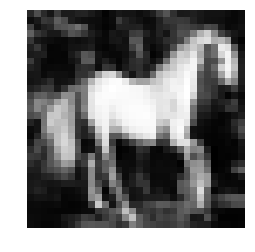

In [22]:
plot_image(test_x[13], shape=[32, 32], cmap = "Greys_r")

![](https://github.com/thomaspernet/Tensorflow/blob/master/tensorflow/22_autoencoder_v4_files/image004.png)

To evaluate the model, you will use the pixel value of this image and
see if the encoder can reconstruct the same image after shrinking 1024
pixels. Note that, you define a function to evaluate the model on
different pictures. The model should work better only on horses.

The function takes two arguments:

-   `df`: Import the test data

-   `image_number`: indicate what image to import

The function is divided into three parts:

1.  Reshape the image to the correct dimension i.e 1, 1024

2.  Feed the model with the unseen image, encode/decode the image

3.  Print the real and reconstructed image

In [23]:
def reconstruct_image(df, image_number = 1):
    ## Part 1: Reshape the image to the correct dimension i.e 1, 1024
    x_test = df[image_number]
    x_test_1 = x_test.reshape((1, 32*32))
    
    ## Part 2: Feed the model with the unseen image, encode/decode the image
    with tf.Session() as sess:     
        sess.run(tf.global_variables_initializer()) 
        sess.run(iter.initializer, feed_dict={x: x_test_1,
                                      batch_size: 1})
    ## Part 3:  Print the real and reconstructed image
      # Restore variables from disk.
        saver.restore(sess, "./model.ckpt")  
        print("Model restored.")
      # Reconstruct image
        outputs_val = outputs.eval()
        print(outputs_val.shape)
        fig = plt.figure()
      # Plot real
        ax1 = fig.add_subplot(121)
        plot_image(x_test_1, shape=[32, 32], cmap = "Greys_r")
      # Plot estimated
        ax2 = fig.add_subplot(122)
        plot_image(outputs_val, shape=[32, 32], cmap = "Greys_r")
        plt.tight_layout()
        fig = plt.gcf()

Now that the evaluation function is defined, you can have a look of the
reconstructed image number thirteen

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
(1, 1024)


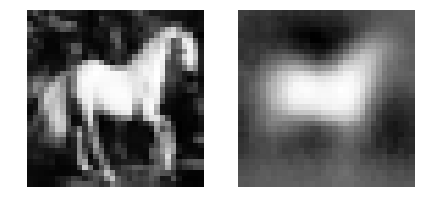

In [24]:
reconstruct_image(df =test_x, image_number = 13)


![](https://github.com/thomaspernet/Tensorflow/blob/master/tensorflow/22_autoencoder_v4_files/image005.png)

## Summary

The primary purpose of an autoencoder is to compress the input data, and
then uncompress it into an output that looks closely like the original
data.

The architecture of an autoencoder symmetrical with a pivot layer named
the central layer.

You can create the autoencoder using:

-   Partial: to create the dense layers with the typical setting:


-   `tf.layers.dense,
activation=tf.nn.elu,
kernel_initializer=xav_init,
kernel_regularizer=l2_regularizer`

-   `dense_layer()`: to make the matrix multiplication

- you can define the loss function and optimization with:
    - `loss = tf.reduce_mean(tf.square(outputs - features)) 
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)`

Last run a session to train the model.